In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

DATA_DIR = "data"

SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]
SELECTED_POSITIONS = ["dom_hand", "nondom_hand", "dom_pocket", "nondom_pocket", "backpack"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2

WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

In [2]:
def load_selected_csvs(base_dir):
    dfs = []

    for activity in SELECTED_ACTIVITIES:
        for position in SELECTED_POSITIONS:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                df = pd.read_csv(csv_path)

                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(
                    os.path.basename(csv_path)
                )[0]

                dfs.append(df)

    print(
        f"Loaded {len(dfs)} recordings | "
        f"Activities={SELECTED_ACTIVITIES} | "
        f"Positions={SELECTED_POSITIONS}"
    )
    return dfs

In [3]:
def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

In [7]:
def extract_features(window, cols):
    feats = []
    for c in cols:
        x = window[c].values
        feats.extend([
            np.mean(x),
            np.std(x),
            np.min(x),
            np.max(x),
            np.sqrt(np.mean(x ** 2)),
            np.sum(np.abs(x)) / len(x)
        ])

        fft_vals = np.fft.rfft(x)
        fft_mag = np.abs(fft_vals)
        fft_mag = fft_mag / len(fft_mag)

        feats.extend([
            np.mean(fft_mag),
            np.std(fft_mag),
            np.max(fft_mag),
            np.sum(fft_mag)
        ])
    return feats
    
def build_dataset(dfs, feature_cols):
    X, y, groups, positions = [], [], [], []

    for df in dfs:
        df = trim_df(df)
        if df is None:
            continue

        for w in sliding_windows(df):
            X.append(extract_features(w, feature_cols))
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])
            positions.append(w["phone_position"].iloc[0])

    return (
        np.array(X),
        np.array(y),
        np.array(groups),
        np.array(positions)
    )

In [8]:
def evaluate_svm(X, y, groups, title):
    gkf = GroupKFold(n_splits=5)

    y_true_all, y_pred_all = [], []

    for train_idx, test_idx in gkf.split(X, y, groups):
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(kernel="rbf", C=1, gamma="scale"))
        ])

        model.fit(X[train_idx], y[train_idx])
        preds = model.predict(X[test_idx])

        y_true_all.extend(y[test_idx])
        y_pred_all.extend(preds)

    print(f"\n=== {title} ===")
    print(classification_report(y_true_all, y_pred_all, digits=4))

    cm = confusion_matrix(
        y_true_all,
        y_pred_all,
        labels=SELECTED_ACTIVITIES
    )

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=SELECTED_ACTIVITIES,
        yticklabels=SELECTED_ACTIVITIES,
        cmap="Blues"
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return {
        "precision": precision_score(y_true_all, y_pred_all, average="macro"),
        "recall": recall_score(y_true_all, y_pred_all, average="macro"),
        "f1": f1_score(y_true_all, y_pred_all, average="macro")
    }

Loaded 100 recordings | Activities=['sit', 'walk', 'run', 'stairs'] | Positions=['dom_hand', 'nondom_hand', 'dom_pocket', 'nondom_pocket', 'backpack']

=== SVM – Raw Device Frame ===
              precision    recall  f1-score   support

         run     0.9960    0.9992    0.9976      1250
         sit     0.9960    0.9888    0.9924      1250
      stairs     0.9132    0.9325    0.9228      1275
        walk     0.9316    0.9152    0.9233      1250

    accuracy                         0.9588      5025
   macro avg     0.9592    0.9589    0.9590      5025
weighted avg     0.9590    0.9588    0.9588      5025



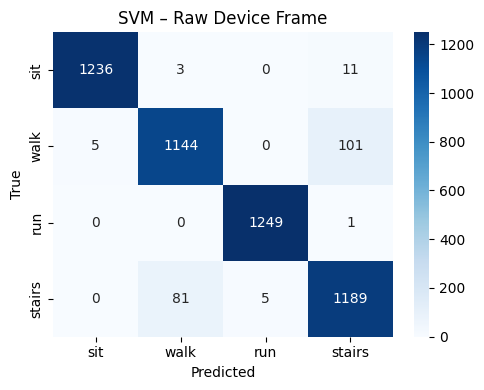


=== SVM – Global Frame (GFT) ===
              precision    recall  f1-score   support

         run     0.9738    0.9800    0.9769      1250
         sit     0.9968    0.9824    0.9895      1250
      stairs     0.9061    0.8933    0.8997      1275
        walk     0.9038    0.9240    0.9138      1250

    accuracy                         0.9447      5025
   macro avg     0.9451    0.9449    0.9450      5025
weighted avg     0.9449    0.9447    0.9447      5025



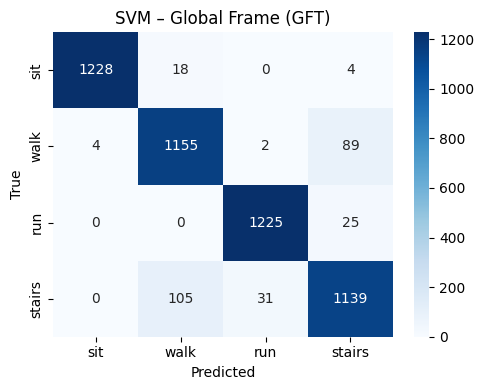


========== SUMMARY ==========
Activities: ['sit', 'walk', 'run', 'stairs']
Positions: ['dom_hand', 'nondom_hand', 'dom_pocket', 'nondom_pocket', 'backpack']
Raw Device Frame: {'precision': 0.959197571745139, 'recall': 0.9589372549019608, 'f1': 0.9590200154617254}
Global Frame (GFT): {'precision': 0.9451006742330672, 'recall': 0.9449333333333333, 'f1': 0.9449621117906198}


In [9]:
if __name__ == "__main__":
    recordings = load_selected_csvs(DATA_DIR)

    # Raw, phone-frame data
    X_raw, y_raw, g_raw, pos_raw = build_dataset(recordings, RAW_FEATURES)
    raw_metrics = evaluate_svm(
        X_raw, y_raw, g_raw,
        "SVM – Raw Device Frame"
    )

    # Global-frame-transformation applied data
    X_gft, y_gft, g_gft, pos_gft = build_dataset(recordings, GFT_FEATURES)
    gft_metrics = evaluate_svm(
        X_gft, y_gft, g_gft,
        "SVM – Global Frame (GFT)"
    )

    print("\n========== SUMMARY ==========")
    print("Activities:", SELECTED_ACTIVITIES)
    print("Positions:", SELECTED_POSITIONS)
    print("Raw Device Frame:", raw_metrics)
    print("Global Frame (GFT):", gft_metrics)